In [9]:
#nescessary libraries
import numpy as np   #linear algebra
import pandas as pd #dataframe maintenance
import os #path listing 
from sklearn.impute import SimpleImputer #Imputation transformer for completing missing values.
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation
from keras.utils import np_utils
from keras import optimizers
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.model_selection import KFold,GridSearchCV

In [10]:
print(os.listdir('./input'))

['gender_submission.csv', 'train.csv', 'test.csv']


In [11]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

In [12]:
def visualise(data,feature_colums):
    plt.figure(figsize=(15,10))
    for i,key in enumerate(feature_colums):
        plt.subplot(len(feature_colums)/3+1,3,i+1)
        data[key].hist()
        plt.title(key)
    plt.show()

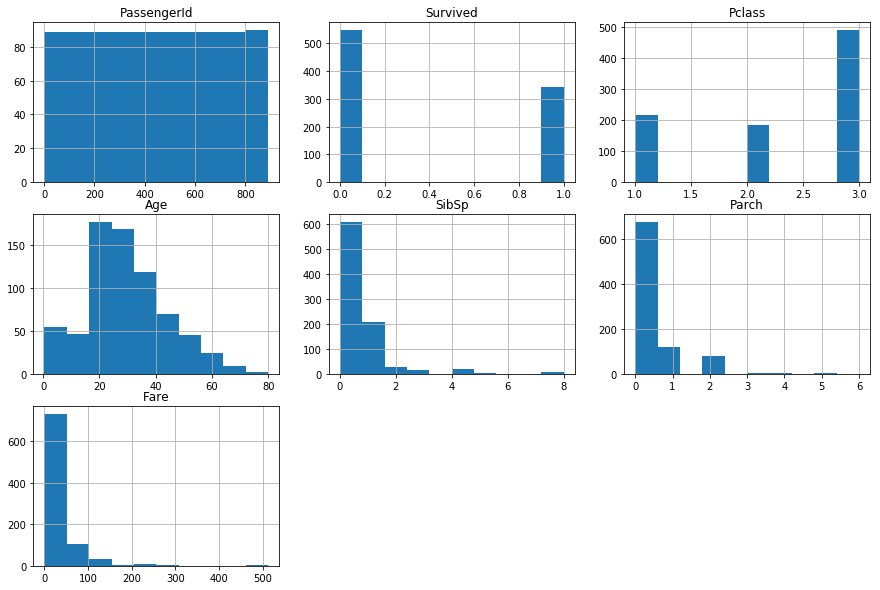

In [13]:
visualise(df_train,[col for col in df_train.columns if df_train[col].dtype != 'object'])

In [29]:
def value_counts(df):
    keys = df.keys()
    for key in keys:
        print(key)
        print(df[key].value_counts())
        print('----------------------------------')
value_counts(df_train)

PassengerId
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
286    1
285    1
284    1
283    1
282    1
281    1
305    1
307    1
279    1
321    1
      ..
561    1
560    1
584    1
585    1
586    1
587    1
610    1
609    1
608    1
607    1
606    1
605    1
604    1
603    1
602    1
601    1
600    1
599    1
598    1
597    1
596    1
595    1
594    1
593    1
592    1
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64
----------------------------------
Survived
0    549
1    342
Name: Survived, dtype: int64
----------------------------------
Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64
----------------------------------
Name
Hunt, Mr. George Henry                                                                1
Natsch, Mr. Charles H                                                          

In [31]:
#function to check for missing values 
def check_missing_values(df):
    print(df.isnull().sum())
check_missing_values(df_train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [34]:
check_missing_values(df_test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [38]:
value_counts(df_train.drop('PassengerId',axis=1))
print('*'*100)
value_counts(df_test.drop('PassengerId',axis=1))

Survived
0    549
1    342
Name: Survived, dtype: int64
----------------------------------
Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64
----------------------------------
Name
Hunt, Mr. George Henry                                                                1
Natsch, Mr. Charles H                                                                 1
Chapman, Mr. Charles Henry                                                            1
Williams-Lambert, Mr. Fletcher Fellows                                                1
Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)                                 1
Mellinger, Miss. Madeleine Violet                                                     1
Strom, Mrs. Wilhelm (Elna Matilda Persson)                                            1
Gronnestad, Mr. Daniel Danielsen                                                      1
Zabour, Miss. Hileni                                                                  1
Penasco y Castel

In [147]:
def preProcessingData(df,feature_columns):
    df = df[feature_columns]
    imputer = SimpleImputer()
    
    df['Age'] = pd.Series(imputer.fit_transform(df.Age.values.reshape(-1,1)).reshape(-1,))
    df['Sex'] = df['Sex'].map(lambda x: 1 if(x=='male') else 0)
    
    if(df.Fare.isnull().any()):
        df['Fare']=pd.Series((imputer.fit_transform(np.array(df['Fare']).reshape(-1,1))).reshape(-1,),name='Fare')
    
    bins = np.linspace(0,100,5)
    df['Fare'] = pd.Series(np.digitize(df['Fare'],bins),name='Fare')
    
    df['Name']=pd.Series(df.Name.str.split(',').str[1].str.split('.').str[0].str.strip())
    df['Name'].replace(to_replace=['Dr','Major','Capt','Sir','Rev','Mlle','Col','Mme','Jonkheer','Don','the Countess','Dona'],value='Master',inplace=True)
    df['Name'].replace(to_replace = ['Lady','Ms'], value = 'Miss', inplace = True)
    
    df['Cabin']=df['Cabin'].apply(lambda x:1 if(x is not np.nan) else 0)
    
    df['FamSize'] = df['SibSp']+df['Parch']+1
    df['FamSize'].replace(to_replace=[2,3,4,5],value=2,inplace=True)
    df['FamSize'].replace(to_replace=[6,7,8,11],value=2,inplace=True)
    
    df['Embarked']=df['Embarked'].fillna('C')
    df['Embarked'].replace(to_replace='C',value=1,inplace=True)
    df['Embarked'].replace(to_replace='C',value=1,inplace=True)
    df['Embarked'].replace(to_replace='S',value=2,inplace=True)
    df['Embarked'].replace(to_replace='Q',value=3,inplace=True)
    
    df=df.drop(['SibSp','Parch'],axis=1)
    
    return df 
    
    
    

In [148]:
targetLabel = df_train['Survived']
feature_columns = ['Pclass','Name','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']

df_test_pp = preProcessingData(df_test,feature_columns)
df_train_pp = preProcessingData(df_train,feature_columns)


/home/xendergrunge/.conda/envs/ashwin/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/xendergrunge/.conda/envs/ashwin/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/xendergrunge/.conda/envs/ashwin/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [149]:
df_merged = pd.concat([df_train_pp,df_test_pp])

In [150]:
def correlationBwData(df,subFeature,mainFeature):
    corr = df.loc[:,subFeature]
    corr = corr.agg(LabelEncoder().fit_transform)
    corr[mainFeature] = df[mainFeature]
    corrData = corr.corr()
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corrData,vmin=-1,vmax=1)
    
    for (i,j),val in np.ndenumerate(corrData):
        ax.text(j,i,'{:0.1f}'.format(val),ha='center',va='center')
    ticks=np.arange(0,len(subFeature)+1,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(subFeature+mainFeature)
    ax.set_yticklabels(subFeature+mainFeature)
    
    plt.show()

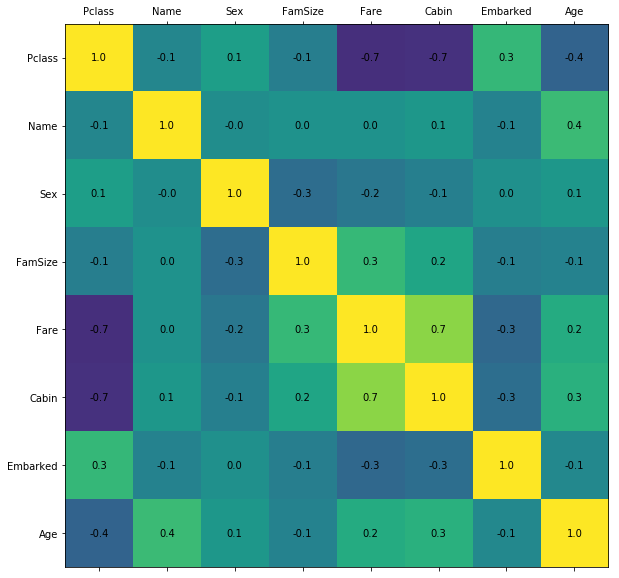

In [154]:
correlationBwData(df_merged,['Pclass','Name','Sex','FamSize','Fare','Cabin','Embarked'],['Age'])

In [153]:
check_missing_values(df_merged)

Pclass      0
Name        0
Sex         0
Age         0
Fare        0
Cabin       0
Embarked    0
FamSize     0
dtype: int64


In [161]:
Age_bins = np.linspace(20,60,3)
df_merged.Age = pd.Series(np.digitize(df_merged.Age,Age_bins),name='Age')

In [167]:
value_counts(df_merged)

Pclass
3    709
1    323
2    277
Name: Pclass, dtype: int64
----------------------------------
Name
Mr        757
Miss      263
Mrs       197
Master     92
Name: Name, dtype: int64
----------------------------------
Sex
1    843
0    466
Name: Sex, dtype: int64
----------------------------------
Age
1    830
0    245
2    198
3     36
Name: Age, dtype: int64
----------------------------------
Fare
1    821
2    246
3     97
5     84
4     61
Name: Fare, dtype: int64
----------------------------------
Cabin
0    1014
1     295
Name: Cabin, dtype: int64
----------------------------------
Embarked
2    914
1    272
3    123
Name: Embarked, dtype: int64
----------------------------------
FamSize
1    790
2    519
Name: FamSize, dtype: int64
----------------------------------


In [169]:
df_merged_one_hot = pd.get_dummies(df_merged)
df_train_pp = df_merged_one_hot.iloc[:df_train_pp.shape[0],:]
df_test_pp = df_merged_one_hot.iloc[df_train_pp.shape[0]:,:]

In [177]:
ntrain=df_train_pp.shape[0]
ntest = df_test_pp.shape[0]
kf = KFold(n_splits=5,random_state=2017)

def get_oof(classifier,train_x,train_y,test_x):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.zeros((5,ntest))
    
    for i,(train_idx,test_idx) in enumerate(kf.split(train_x)):
        kf_train_x = train_x.iloc[train_idx]
        kf_train_y = train_y[train_idx]
        kf_test_x = train_x.iloc[test_idx]
        
        classifier.fit(kf_train_x,kf_train_y)
        oof_train[test_idx] = classifier.predict(kf_test_x)
        oof_test_skf[i,:] = classifier.predict(test_x)
    
    oof_test = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [183]:
def tuneParams(classifier,params,train_x,train_y):
    md = GridSearchCV(classifier,params,cv=10,scoring='accuracy',n_jobs=4)
    md.fit(train_x,train_y)
    best_params,best_score = md.best_params_,np.round(md.best_score_*100,2)
    
    return best_params,best_score


In [184]:
xgbParams = {'max_depth':[3,5,8,10],'learning_rate':[0.01,0.1,0.5],'n_estimator':[100,300,500],'gamma':[0.01,0.05,0.1,0.5]}
ABParams = {'n_estimators':[100,300,500],'learning_rate':[0.01,0.5,0.1,0.5]}
RFParams = {'n_estimators':[10,30,50],'max_depth':[3,5,8,10],'min_samples_split':[2,5,10],'min_samples_leaf':[2,4,10],'random_state':[5]}
ETParams = {'n_estimators':[100,300,500],'max_depth':[3,8,12],'min_samples_leaf':[2,4,9],'verbose':[0]}
KNNParams = {'n_neighbors':[3,8,14],'leaf_size':[2,5,9],'weights':['uniform']}
SVCParams = {'C':[0.01,0.1,0.5],'gamma':[0.01,0.2]}

In [185]:
xgb_best_Params,xgb_best_score = tuneParams(XGBClassifier(),xgbParams,df_train_pp,targetLabel)
print("XGB:",xgb_best_Params,xgb_best_score)
#====================================================================

AB_best_Params,AB_best_score = tuneParams(AdaBoostClassifier(),ABParams,df_train_pp,targetLabel)
print("AdaBoost:",AB_best_Params,AB_best_score)
#====================================================================

RF_best_Params,RF_best_score = tuneParams(RandomForestClassifier(),RFParams,df_train_pp,targetLabel)
print("RandomForest:",RF_best_Params,RF_best_score)
#====================================================================

ET_best_Params,ET_best_score = tuneParams(ExtraTreesClassifier(),ETParams,df_train_pp,targetLabel)
print("ExtraTrees:",ET_best_Params,ET_best_score)
#====================================================================

KNN_best_Params,KNN_best_score = tuneParams(KNeighborsClassifier(),KNNParams,df_train_pp,targetLabel)
print("KNeighbors:",KNN_best_Params,KNN_best_score)
#====================================================================

SVC_best_Params,SVC_best_score = tuneParams(SVC(),SVCParams,df_train_pp,targetLabel)
print("SVC:",SVC_best_Params,SVC_best_score)

XGB: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimator': 100} 83.84
AdaBoost: {'learning_rate': 0.5, 'n_estimators': 100} 80.81
RandomForest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10, 'random_state': 5} 83.5
ExtraTrees: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 500, 'verbose': 0} 83.28
KNeighbors: {'leaf_size': 5, 'n_neighbors': 8, 'weights': 'uniform'} 81.71
SVC: {'C': 0.5, 'gamma': 0.2} 83.16


In [191]:
processed_train_data = df_train_pp.copy(deep=True)
TargetLabel=targetLabel.copy()
processed_test_data = df_test_pp.copy()

xgb_oof_train,xgb_oof_test = get_oof(XGBClassifier(**xgb_best_Params),processed_train_data,TargetLabel,processed_test_data)
AB_oof_train,AB_oof_test = get_oof(AdaBoostClassifier(**AB_best_Params),processed_train_data,TargetLabel,processed_test_data)
RF_oof_train,RF_oof_test = get_oof(RandomForestClassifier(**RF_best_Params),processed_train_data,TargetLabel,processed_test_data)
ET_oof_train,ET_oof_test = get_oof(ExtraTreesClassifier(**ET_best_Params),processed_train_data,TargetLabel,processed_test_data)
KNN_oof_train,KNN_oof_test =  get_oof(KNeighborsClassifier(**KNN_best_Params),processed_train_data,TargetLabel,processed_test_data)
SVC_oof_train,SVC_oof_test = get_oof(SVC(**SVC_best_Params),processed_train_data,TargetLabel,processed_test_data)

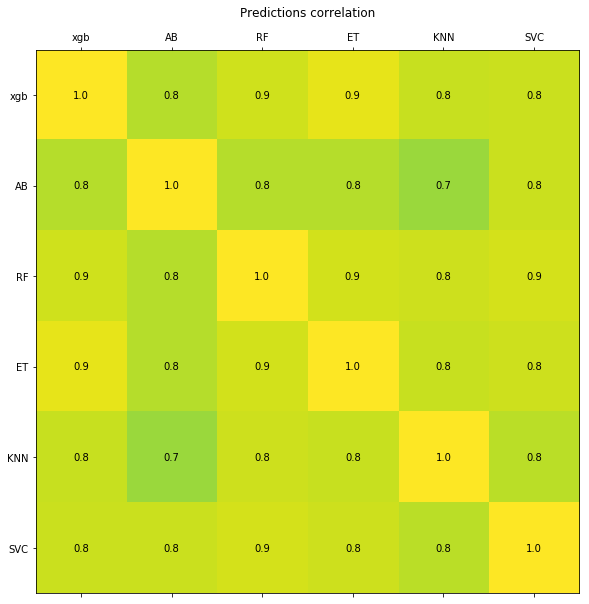

In [197]:
model_predictions = pd.DataFrame(np.concatenate((xgb_oof_train,AB_oof_train,RF_oof_train,ET_oof_train,KNN_oof_train,SVC_oof_train),axis=1))
model_name = ['xgb','AB','RF','ET','KNN','SVC']
prediction_corr = model_predictions.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(prediction_corr,vmin=-1,vmax=1)
    
for(i,j),val in np.ndenumerate(prediction_corr):
    ax.text(j,i,'{:0.1f}'.format(val),ha='center',va='center')
    
ticks = np.arange(0,len(model_name),1)
ax.set_title('Predictions correlation')
ax.set_xticks(ticks)
ax.set_yticks(ticks)
    
ax.set_xticklabels(model_name)
ax.set_yticklabels(model_name)
plt.show()

In [198]:
final_train = np.concatenate((xgb_oof_train,RF_oof_train,ET_oof_train,KNN_oof_train,SVC_oof_train),axis=1)
final_test = np.concatenate((xgb_oof_test,RF_oof_test,ET_oof_test,KNN_oof_test,SVC_oof_test),axis=1)

In [199]:
LRParams = {'penalty':['l1','l2'],'C':[0.01,0.05,0.1,0.2]}
LR_best_Params,LR_best_score = tuneParams(LogisticRegression(),LRParams,final_train,TargetLabel)
print("LR:",LR_best_Params,LR_best_score)

LR: {'C': 0.05, 'penalty': 'l1'} 83.61


/home/xendergrunge/.conda/envs/ashwin/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [207]:
LR_model = LogisticRegression(**LR_best_Params)
LR_model.fit(final_train,TargetLabel)
prediction = LR_model.predict(final_test)

/home/xendergrunge/.conda/envs/ashwin/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [208]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S
